In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [1]:
import plotly
import numpy as np
from keras import layers, models, optimizers, callbacks
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image
from capsule_layers import CapsuleLayer, PrimaryCap, Length, Mask
from capsule_network import CapsNet, margin_loss

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

Using TensorFlow backend.


In [2]:
epochs = 50
batch_size = 100
lr = 0.001
lr_decay = 0.9
lam_recon = 0.392
routing = 3
shift_fraction = 0.1
model_path = 'models/model-2d.h5'
digits = 10
saved_weights = None

In [3]:
def load_mnist():
    # the data, shuffled and split between train and test sets
    from keras.datasets import mnist
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.
    y_train = to_categorical(y_train.astype('float32'))
    y_test = to_categorical(y_test.astype('float32'))
    return (x_train, y_train), (x_test, y_test)

# load data
(x_train, y_train), (x_test, y_test) = load_mnist()

In [4]:
# define model
model, eval_model, _ = CapsNet(input_shape=x_train.shape[1:],
                                              n_class=len(np.unique(np.argmax(y_train, 1))),
                                              routings=routing)

In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 20, 20, 256)  20992       input_1[0][0]                    
__________________________________________________________________________________________________
primarycap_conv2d (Conv2D)      (None, 6, 6, 256)    5308672     conv1[0][0]                      
__________________________________________________________________________________________________
primarycap_reshape (Reshape)    (None, 1152, 8)      0           primarycap_conv2d[0][0]          
__________________________________________________________________________________________________
primarycap

In [6]:
checkpoint = callbacks.ModelCheckpoint(model_path, 
                                       monitor='val_capsnet_acc', 
                                       save_best_only=True, 
                                       save_weights_only=True, 
                                       verbose=1)
earlystopper = callbacks.EarlyStopping(monitor='val_capsnet_acc', patience=3, verbose=0)
#lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: lr * (lr_decay * epoch * epoch))

In [7]:
# compile the model
model.compile(optimizer=optimizers.Adam(lr=lr),
              loss=[margin_loss, 'mse'],
              loss_weights=[1., lam_recon],
              metrics={'capsnet': 'accuracy'})

In [8]:
model.fit([x_train, y_train], 
          [y_train, x_train], 
          batch_size=batch_size, 
          epochs=epochs,
          validation_data=[[x_test, y_test], [y_test, x_test]], 
          callbacks=[earlystopper, checkpoint])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 120s 2ms/step - loss: 0.7870 - capsnet_loss: 0.7582 - decoder_loss: 0.0733 - capsnet_acc: 0.1607 - val_loss: 0.0962 - val_capsnet_loss: 0.0753 - val_decoder_loss: 0.0533 - val_capsnet_acc: 0.9534

Epoch 00001: val_capsnet_acc improved from -inf to 0.95340, saving model to models/model-2d.h5
Epoch 2/50
60000/60000 [==============================] - 116s 2ms/step - loss: 0.0506 - capsnet_loss: 0.0312 - decoder_loss: 0.0497 - capsnet_acc: 0.9775 - val_loss: 0.0373 - val_capsnet_loss: 0.0193 - val_decoder_loss: 0.0459 - val_capsnet_acc: 0.9856

Epoch 00002: val_capsnet_acc improved from 0.95340 to 0.98560, saving model to models/model-2d.h5
Epoch 3/50
60000/60000 [==============================] - 116s 2ms/step - loss: 0.0342 - capsnet_loss: 0.0170 - decoder_loss: 0.0440 - capsnet_acc: 0.9878 - val_loss: 0.0311 - val_capsnet_loss: 0.0146 - val_decoder_loss: 0.0421 - val_capsnet_acc: 

In [3]:
import numpy as np
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.5/dist-packages/tornado/platf

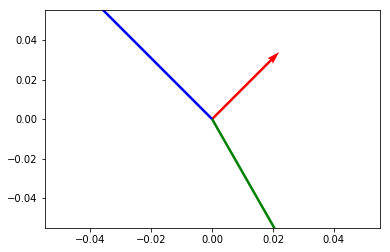

In [12]:
V = np.array([[1,1],[-2,2],[4,-7]])
origin = [0], [0] # origin point

plt.quiver(*origin, V[:,0], V[:,1], color=['r','b','g'], scale=5)
plt.show()

In [5]:
def squash(s):
    pls = np.sum(s * s)
    ls  = np.sqrt(pls)
    return (pls/(1+pls))*(s / ls)

In [7]:
sV = squash(V)

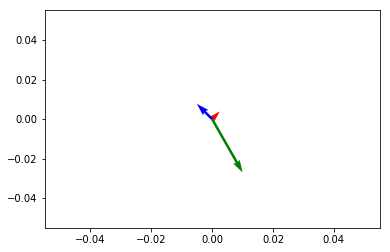

In [11]:
plt.quiver(*origin, sV[:,0], sV[:,1], color=['r','b','g'], scale=5)
plt.show()

In [30]:
a = np.array([10, 8, 10])
def softmax(x):
     return (np.exp(-x) / np.sum(np.exp(-x)))

In [31]:
soft_a = softmax(a)
print(soft_a)
print(np.sum(soft_a))

[0.10650698 0.78698604 0.10650698]
1.0000000000000002


In [18]:
a = np.array([10, 0, 0])
def inv_softmax(x):
     return 1 / (np.exp(x) / np.sum(np.exp(x)))

In [19]:
inv_soft_a = inv_softmax(a)
print(inv_soft_a)

[1.00009080e+00 2.20284658e+04 2.20284658e+04]
